# Relative & Absolute Table Refresh Durations in Power BI
> Few ways to get relative & abolsute refresh durations in Power BI

- toc: true 
- badges: true
- comments: true
- categories: [powerbi, tuning, optimization]
- hide: false

In [124]:
#hide_input
import adodbapi
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings('ignore')

## Overview

When designing models and queries in Power BI dekstop, you often need to measure the individual dataset refresh duration. This is particularly important for large datasets where you are trying to optimize the queries to reduce the refresh time during development and in service. Matthew Roche from Power BI CAT team [asked a question recently on Twitter](https://twitter.com/SQLAllFather/status/1478918643744272386?s=20&t=pJZyCVjTYk8qK8f-Bb_ezw) about measuring refresh duration. Most pointed to Phil Seamark's [Visualize Your Power BI Refresh](https://dax.tips/2021/02/15/visualise-your-power-bi-refresh/) blog and tool. I use that tool and it was the only way I was aware of. But Power BI user [Eric Beery](https://twitter.com/eric_beery11) responded with an interesting solution that I didn't know about. In this blog I am exploring that solution. 

**All credit goes to Eric for this solution**

>twitter:https://twitter.com/eric_beery11/status/1478925334812704776?s=20&t=pJZyCVjTYk8qK8f-Bb_ezw

## Relative Refresh

### Solution 1 : The Easy Way
##### Hovering over the table name

If you hover the table in report view or model view, you can get the "Data refreshed" date and time. Unfortunately it doesn't give you the data refresh start time so it's not possible to get the exact duration. We can get the relative refresh time by looking at when the refresh finished for a table with little/no data. For example, the small table below finished refreshing at 11:51:39 AM and the large table finished at 11:52:15 AM. So the refresh time for the large table was roughly 45 seconds longer than the small table. This obvisouly doesn't help us a lot but that's the basic idea.

![](https://raw.githubusercontent.com/pawarbi/blog/master/images/r1.gif)

>note: This assumes the refreshes happen in parallel. If you have disabled "Allow parallel loading of tables" under options, tables will be refreshed sequentially in which case this doesn't help. 

We can improvise this by adding a blank table by clicking on **"Enter data"** on the home tab. This will create a blank table without any rows. The idea here is that the blank table should take the least amount of time and thus should be close to the start of refresh time. We can use that to get a better estimation of *relative* refresh duration.



![](https://raw.githubusercontent.com/pawarbi/blog/master/images/r2.png)



As you can in the image below, the empty table loaded at 12:51:25PM and the large table finished refreshing at 12:51:52PM, thus the large table takes roughly ~25 seconds to load. It took a bit longer in the first attempt because it was the first refresh. I am guessing when I refreshed again, the connection & data were already cached so it was faster. 


![](https://raw.githubusercontent.com/pawarbi/blog/master/images/r3.gif)

### Solution 2 : Selective Refresh Duration
##### Refresh duration for a specific table

As noted above, the limitation of this method is that we it won't work withour enabling parallel load. Also, even when parallel load in enabled, the query might wait for other queries to connect/refresh which will give false duration. We can get around this by refreshing only select few tables. This is not possibel in the report view, but if we switch to model view, we can CNTRL + Select the tables to refresh. This will provide slightly more accurate relative refresh time and we don't have to wait for all the queries to refresh. This is a better way when working with many tables or when you have a large table. 

![](https://raw.githubusercontent.com/pawarbi/blog/master/images/r4.gif)

### Solution 3 : Using DMV
##### Getting refresh times using DMV

Since this is all metadata, I thought I could query the DMV to get the same information. If we query *TMSCHEMA_PARTITIONS* using DAX Studio, we can get the same refresh times. 

![](https://raw.githubusercontent.com/pawarbi/blog/master/images/r5.png)

Note in this case, there are two times- ModifiedTime and RefreshedTime. ModifiedTime tells you when the table was last saved/modified and RefreshedTime tells you when the data was refreshed. It is Also note that the times are in UTC time zone and since we are using MDX, there is no way to convert it to local time zone in DAX Studio, at least I am not aware of it. 

Using DMV gives us partition level refresh time. This helped in a project where I had to partition a massive dataset and wanted to know how well it was working. Querying the DMV allowed me to tune the size/number of partitions. 

DAX Studio can connect to published datasets in service. So using this method, we can even check the refresh times for tables in a published datasets. Below I am using Python to connect to a published dataset and query the DMV.

In [112]:
import adodbapi as ado



conn = adodbapi.connect("Provider=MSOLAP.8; Data Source = 'powerbi://api.powerbi.com/v1.0/myorg/<workspace>';initial catalog='<dataset name>'")
cstring = "Provider=MSOLAP.8; Data Source = 'powerbi://api.powerbi.com/v1.0/myorg/<workspace>';initial catalog='<dataset name>'"
cur = conn.cursor()


with ado.connect(cstring) as con:
    with con.cursor() as cur:
        dax_str = ''' select [Name]
    ,[ModifiedTime]
    ,[RefreshedTime] 

from $SYSTEM.TMSCHEMA_PARTITIONS '''
        cur.execute(dax_str)
        data = cur.fetchall()


Convert the DMV data to a pandas dataframe

In [113]:
def get_dmv(data):
    '''
    Original script: https://stackoverflow.com/questions/56075159/convert-listadodbapi-apibase-sqlrow-to-pd-dataframe
    
    Modified to make changes to retrieve the DMV data
    
    Input: Pandas dataframe
    Return: Pandas dataframe with columns convrted to datetime 
    
    Author: Sandeep Pawar
    
    
    '''
    cols = pd.DataFrame(np.array(data.ado_results)).iloc[0]
    values =  pd.DataFrame(np.array(data.ado_results)).iloc[1:]
    for col in list(values.columns):
        values[col]=pd.to_datetime(values[col]).dt.tz_convert("UTC")
    values.columns = cols    
    df = values.T
    df.columns = ['ModifiedTime','RefreshedTime']
    
    
    return df



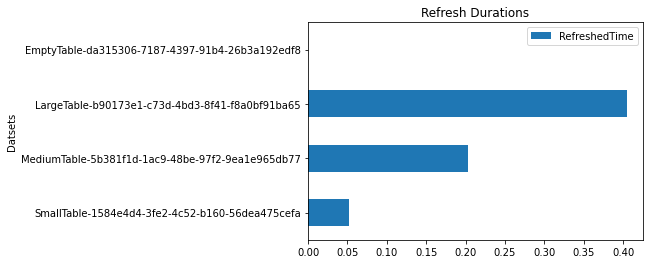

In [121]:
df = get_dmv(data)
((df[['RefreshedTime']]-df[['RefreshedTime']].min())/np.timedelta64(1,'m')).plot.barh(title = "Refresh Durations", xlabel='Datsets');

For the same dataset published to service, I deducted the refres time of teh empty table from rest of the times to get relatove refresh duration. Yo can use SSMS/Tabular Editor to selectively refresh datasets (just like above) and get more relatively accurate refresh durations.

In the same twitter thread, Imke Feldmann showed that she has incorporated a similar approach in her Power BI Cleaner tool. Take a look at it below:

>twitter: https://twitter.com/TheBIccountant/status/1478975202981724162?s=20&t=pJZyCVjTYk8qK8f-Bb_ezw


## Absolute Refresh

### Solution 4 : Using SQL Server Profiler with "Visualize My Refresh"
##### The most accurate method

The most accurate and reliable way to capture refresh durations are by using the SQL Server Profiler and [Phil Seamark's](https://dax.tips/) "Visualize My Refresh" [report](https://dax.tips/2021/02/15/visualise-your-power-bi-refresh/). Phil will explain it better than I can so watch below:
![](https://raw.githubusercontent.com/pawarbi/blog/master/images/r6.png)

>youtube: https://youtu.be/Y1B3HmGtGB0

If you have any thoughts on improving these solutions, please let me know.